# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 2. Поиск по образцу.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы второй практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [1]:
import os

practice_dir_path = '/Users/lisisian/VS-code/TimeSeries/2025-Cherkasov-TimeSeriesCourse/practice/02 Similarity search'

os.chdir(practice_dir_path)

Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [2]:
%load_ext autoreload
%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 2.

In [3]:
pip install mass-ts


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade numpy pandas


  Using cached numpy-2.3.3-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.3.3-cp313-cp313-macosx_14_0_arm64.whl (5.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import math
import timeit
import random
import mass_ts as mts
from IPython.display import display

from modules.distance_profile import brute_force
from modules.prediction import *
from modules.bestmatch import *
from modules.utils import *
from modules.plots import *
from modules.experiments import *

## **Часть 1.** Поиск по образцу на основе вычисленного профиля расстояния.

**Задача поиска по образцу (subsequence matching)** заключается в нахождении $topK$ наиболее похожих подпоследовательностей временного ряда $T$ длины $n$ на заданный пользователем существенно более короткий временной ряд $Q$ длины $m$, называемый запросом, в смысле некоторой функции расстояния, $m \ll n$. При этом среди найденных подпоследовательностей не должно быть тривиальных совпадений.

Две подпоследовательности $T_{i,m}$ и $T_{j,m}$ временного ряда $T$ являются **тривиальными совпадениями (trivial matches)**, если они пересекаются:
\begin{equation}
|i-j| \leqslant m.
\end{equation}

В общем случае условие пересечения записывается как $|i-j| \leqslant \xi m$, где задаваемый экспертом вещественный параметр $\xi$ $(0 < \xi \leqslant 1)$ имеет типичные значения 0.25, 0.5 или 1.

Одним из вариантов решения данной задачи является вычисление профиля расстояния. Под **профилем расстояния** $DistProfile\in \mathbb{R}^{n-m+1}$ понимается вектор, содержащий расстояния между подпоследовательностями временного ряда $T \in \mathbb{R}^n$ и запросом $Q \in \mathbb{R}^m$, вычисленные с помощью некоторой неотрицательной симметричной функции расстояния $dist(\cdot,\cdot)$:  
\begin{equation}
DistProfile(i) = dist(Q, T_{i,m}), \quad 1 \leqslant i \leqslant n-m+1.
\end{equation}

На основе вычисленного профиля расстояния в качестве $topK$ похожих подпоследовательностей ряда берутся те, которые имеют наименьшие расстояния до запроса:
\begin{equation}
C_{match} = \{T_{i,m}^k\}_{k=1}^{topK},\; где \; T_{i,m}^k \in T, \; i = argsort(DistProfile)(k), \; 1 \leqslant i \leqslant n-m+1.
\end{equation}

В части 1 практической работы 2 вы рассмотрите несколько алгоритмов вычисления профиля расстояния на примере алгоритмов грубой силы и MASS, а также примените результаты их выполнения для решения задачи поиска по образцу. В таблице ниже представлено их тезисное описание.

| <h5> **Алгоритм** </h5> | <h5> **Описание** </h5> | <h5> **Вычислительная <br> сложность** </h5> |
|--------------|------------------------------------------------------------------|:-----------------------------:|
| <p>Brute Force</p>  | <ul><li>Наивный алгоритм</li><li>Z-нормализация запроса и подпоследовательностей ряда по стандартным формулам</li><li>Полное вычисление расстояний между запросом и подпоследовательностями ряда</li></ul> |            <p>$O(mn)$</p>            |
| <p>MASS 1</p>       | <ul><li>Z-нормализация &#171;на лету&#187;</li><li>Применение свертки для вычисления скалярных произведений <br> между запросом и подпоследовательностями ряда</li><li>Выполнение свертки с помощью быстрого преобразования Фурье</li><li>Дополнение справа нулями запроса и временного ряда до удвоенной длины ряда</li><li>Реверс запроса</li></ul> |          <p>$O(n\log{n})$</p>          |
| <p>MASS 2</p>       | <ul><li>MASS 1 – это алгоритм, на котором основан MASS 2</li><li>Вычисление половины свертки</li><li>Дополнение нулями справа только запроса до длины временного ряда</li></ul> |          <p>$O(n\log{n})$</p>          |
| <font size="3">MASS 3</font>       | <ul><li>MASS 2 – это алгоритм, на котором основан MASS 3</li><li>Посегментная обработка временного ряда</li><li>Длина каждого сегмента (кроме, возможно, последнего) – степень двойки</li><li>Сегменты перекрываются на $m-1$ элементов</li></ul> |             <p>$O(\frac{n-k}{k-m}k\log{k})$, <br> где $k$ – длина сегмента </p>           |

### **Задача 1.**

В данном задании вам предстоит определить, имеет ли пациент заболевание сердца по снятой записи ЭКГ или нет. Решать данную задачу будем с помощью алгоритмов поиска по образцу.

Сначала выполните считывание временного ряда и образца поиска из файлов *ECG.csv* и *ECG_query.csv* соответственно из директории *./datasets/part1*. Временной ряд представляет собой показания ЭКГ пациента, образец поиска – фрагмент ЭКГ, обозначающий некоторое кардиологическое заболевание.

In [ ]:
import numpy as np
import pandas as pd
import math
import timeit
import random
import mass_ts as mts
from IPython.display import display

from modules.distance_profile import brute_force
from modules.prediction import *
from modules.bestmatch import *
from modules.utils import *
from modules.plots import *
from modules.experiments import *
ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

/Users/lisisian/VS-code/TimeSeries/2025-Cherkasov-TimeSeriesCourse/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/Users/lisisian/VS-code/TimeSeries/2025-Cherkasov-TimeSeriesCourse/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Далее выполните визулизацию временного ряда и образца поиска с помощью функции `plot_bestmatch_data()` из модуля *plots.py*.

In [8]:
plot_bestmatch_data(ts, query)

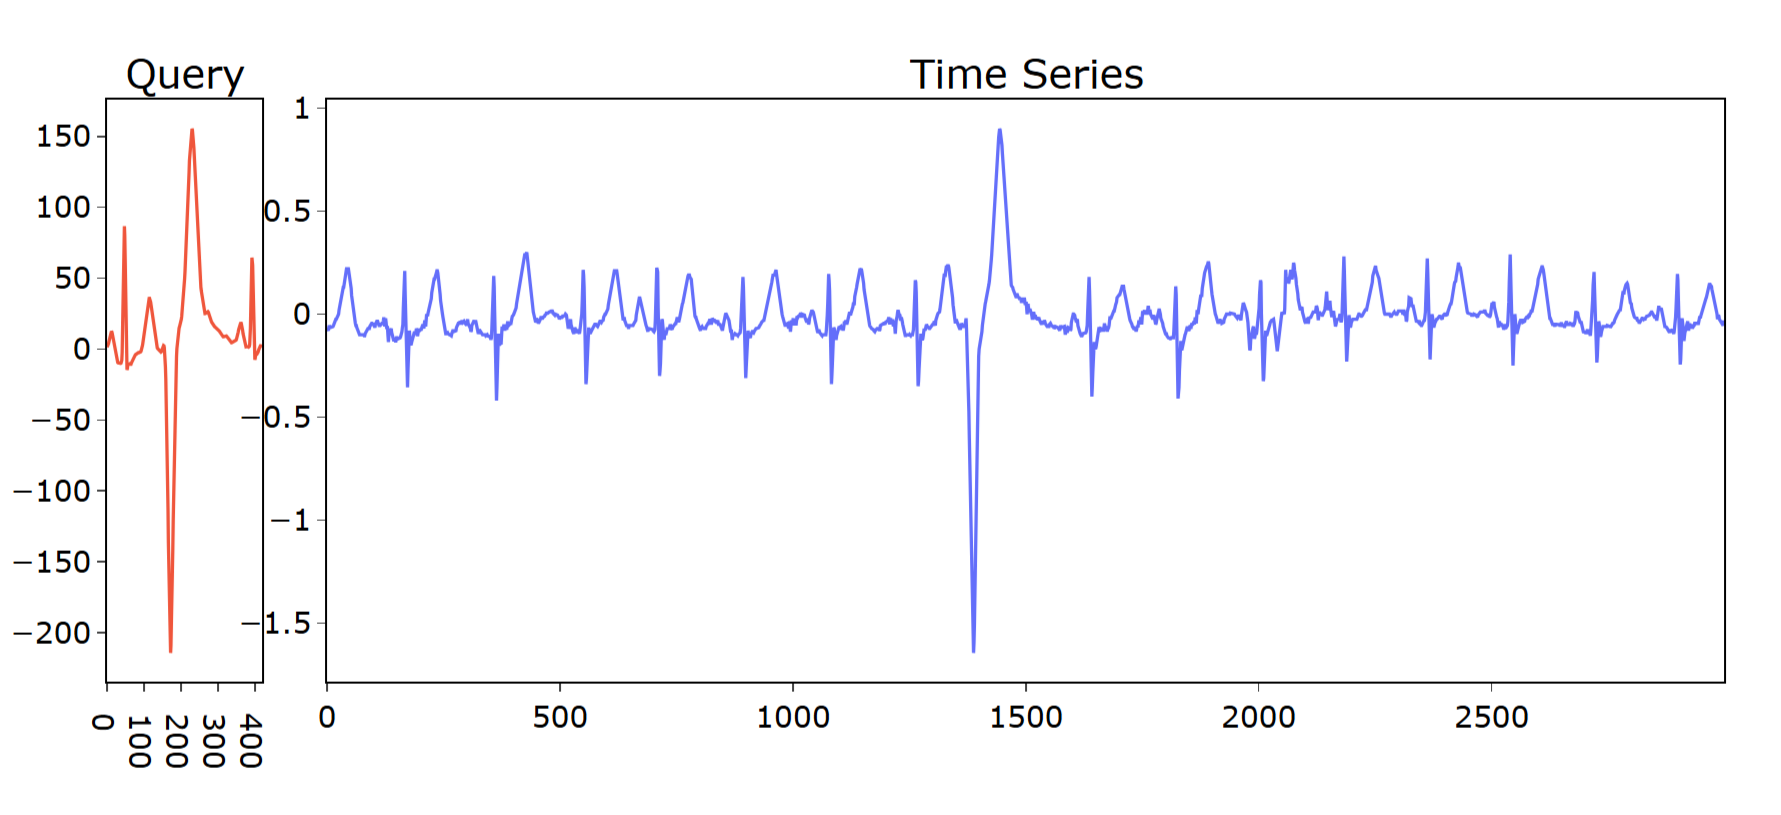

Реализуйте алгоритм грубой силы (brute force), заполнив одноименную функцию в модуле *distance_profile.py* недостающим кодом. Для этого воспользуйтесь псевдокодом алгоритма, который представлен ниже. После того как вычислен профиль расстояния, найдите $topK$ похожих подпоследовательностей на запрос с помощью функции `topK_match()` из *bestmatch.py*. Для исключения попадания тривиальных совпадений зададим $\xi = 0.5$ Далее параметр $\xi$ будем обозначать в коде как $excl\_zone\_frac$, а величину пересечения как $excl\_zone$, $excl\_zone = \lceil excl\_zone\_frac \cdot m \rceil$,

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/brute_force.png?raw=true" width="400"></center>

In [9]:
from modules.distance_profile import brute_force
# Данные
topK = 2
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)
is_normalize = True

# Вычисление профиля расстояния с использованием brute force
dist_profile = brute_force(ts, query, is_normalize = True)

# Поиск topK совпадений
naive_bestmatch_results = topK_match(dist_profile, excl_zone, topK)
naive_bestmatch_results
# Результат
print("Лучшие совпадения:", naive_bestmatch_results)


Лучшие совпадения: {'indices': [1215, 193], 'distances': [5.016417971728831, 18.030850173768773]}


Напишите функцию `plot_bestmatch_results()` в модуле *plots.py* для визуализации найденных $topK$ похожих подпоследовательностей временного ряда на образец поиска. За основу возьмите функцию `plot_bestmatch_data()` и добавьте отображение найденных подпоследовательностей, выделив их тем же цветом, что и образец поиска.

In [10]:
plot_bestmatch_results(ts, query, naive_bestmatch_results)

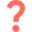
Определите по полученным результатам, имеет ли человек сердечное заболевание или нет.

Необычные пик или аномалию в сигнале ( сильные отклонение ) может указывать на аритмию или другие сердечные проблемы. Однако, без более подробного контекста сложно однозначно сказать, но большая вероятность, судя по графику, у пациента заболевание.

### **Задача 2.**

Проделайте такие же шаги для поиска по образцу, как и в задаче 1, но теперь вычислите профиль расстояния с помощью одной из выбранных вами версий алгоритма MASS. Для этого используйте стороннюю библиотеку *mass-ts*. Со списком всех функций, которые предоставляет данная библиотека, и их описанием вы можете ознакомиться в [репозитории библиотеки GitHub](https://github.com/matrix-profile-foundation/mass-ts).

Обратите внимание, что MASS 2 и MASS 3 возвращают профиль расстояния в виде вектора комплексных чисел. Для дальнейшей работы с профилем расстояния используйте только вещественные части комплексных чисел.     

In [10]:
pip install mass-ts

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install mass-ts[gpu]

zsh:1: no matches found: mass-ts[gpu]
Note: you may need to restart the kernel to use updated packages.


In [13]:
import mass_ts as mts
import math

# Параметры для поиска
topK = 2
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)
is_normalize = True
# mass
distances = mts.mass(ts, query)

# mass2
distances = mts.mass2(ts, query)

# Вычисление профиля расстояний с помощью алгоритма MASS
#distance_profile_mass = mts.mass(query, ts)
distance_profile_mass = distances
#  берём только вещественную часть
distance_profile_mass_real = distance_profile_mass.real

# Поиск topK совпадений
naive_bestmatch_results_mass = topK_match(distance_profile_mass_real, excl_zone, topK)

# Результат
print("Лучшие совпадения (MASS):", naive_bestmatch_results_mass)

# Визуализация совпадений
plot_bestmatch_results(ts, query, naive_bestmatch_results_mass)


Лучшие совпадения (MASS): {'indices': [1215, 193], 'distances': [5.016417971728845, 18.030850173768773]}


### **Задача 3.**

Проведите две серии экспериментов по сравнению быстродействия алгоритмов грубой силы и трех версий MASS:
1. на фиксированной длине запроса $m$ при изменяемой длине временного ряда $n$;
2. на фиксированной длине временного ряда $n$ при изменяемой длине запроса $m$.

Все необходимые для проведения экспериментов функции находятся в модуле *experiments.py*.

Сначала сгенерируйте по аналогии временные ряды и запросы поиска различных длин, как это было сделано в практической работе 1. Далее измерьте время выполнения алгоритмов при заданных входных параметрах и данных с помощью функции `run_experiment()`. Полученные результаты (время выполнения) каждого эксперимента отобразите на линейном графике, воспользовавшись функцией `visualize_plot_times()`.

Также вычислите ускорение с помощью функции `calculate_speedup()`, показывающее, во сколько раз алгоритм MASS превосходит по времени выполнения алгоритма грубой силы, по следующей формуле:
\begin{equation}
speedup = \frac{t_{BF}}{t_{MASS}},
\end{equation}
где $t_{BF}$ и $t_{MASS}$ — время работы алгоритма грубой силы и MASS соответственно.

Полученные ускорения оформите в виде таблицы, для построения используйте функцию `visualize_table_speedup()`.

Эксперимент 1

In [14]:
algorithms = ['brute_force', 'mass', 'mass2', 'mass3']
algorithms_params = {
    'brute_force': None,
    'mass': None,
    'mass2': None,
    'mass3': {'segment_len': 2048},
}

n_list = [2**15, 2**16, 2**17, 2**18, 2**19, 2**20] # lengths of time series
m = 128 # length of query

exp1_params = {
    'varying': {'n': n_list},
    'fixed': {'m': m}
}

exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'distance_profile'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes


In [15]:
import numpy as np



In [16]:
# Запуск эксперимента 1: Измерение времени выполнения алгоритмов
times_exp1 = np.array([run_experiment(alg, 'distance_profile', exp1_data, exp1_params, algorithms_params.get(alg)) for alg in algorithms])


In [17]:
# visualize plot with results of experiment
comparison_param = np.array(algorithms)



In [18]:
# Визуализация результатов эксперимента 1: Время выполнения
visualize_plot_times(times_exp1, np.array(algorithms), exp1_params)

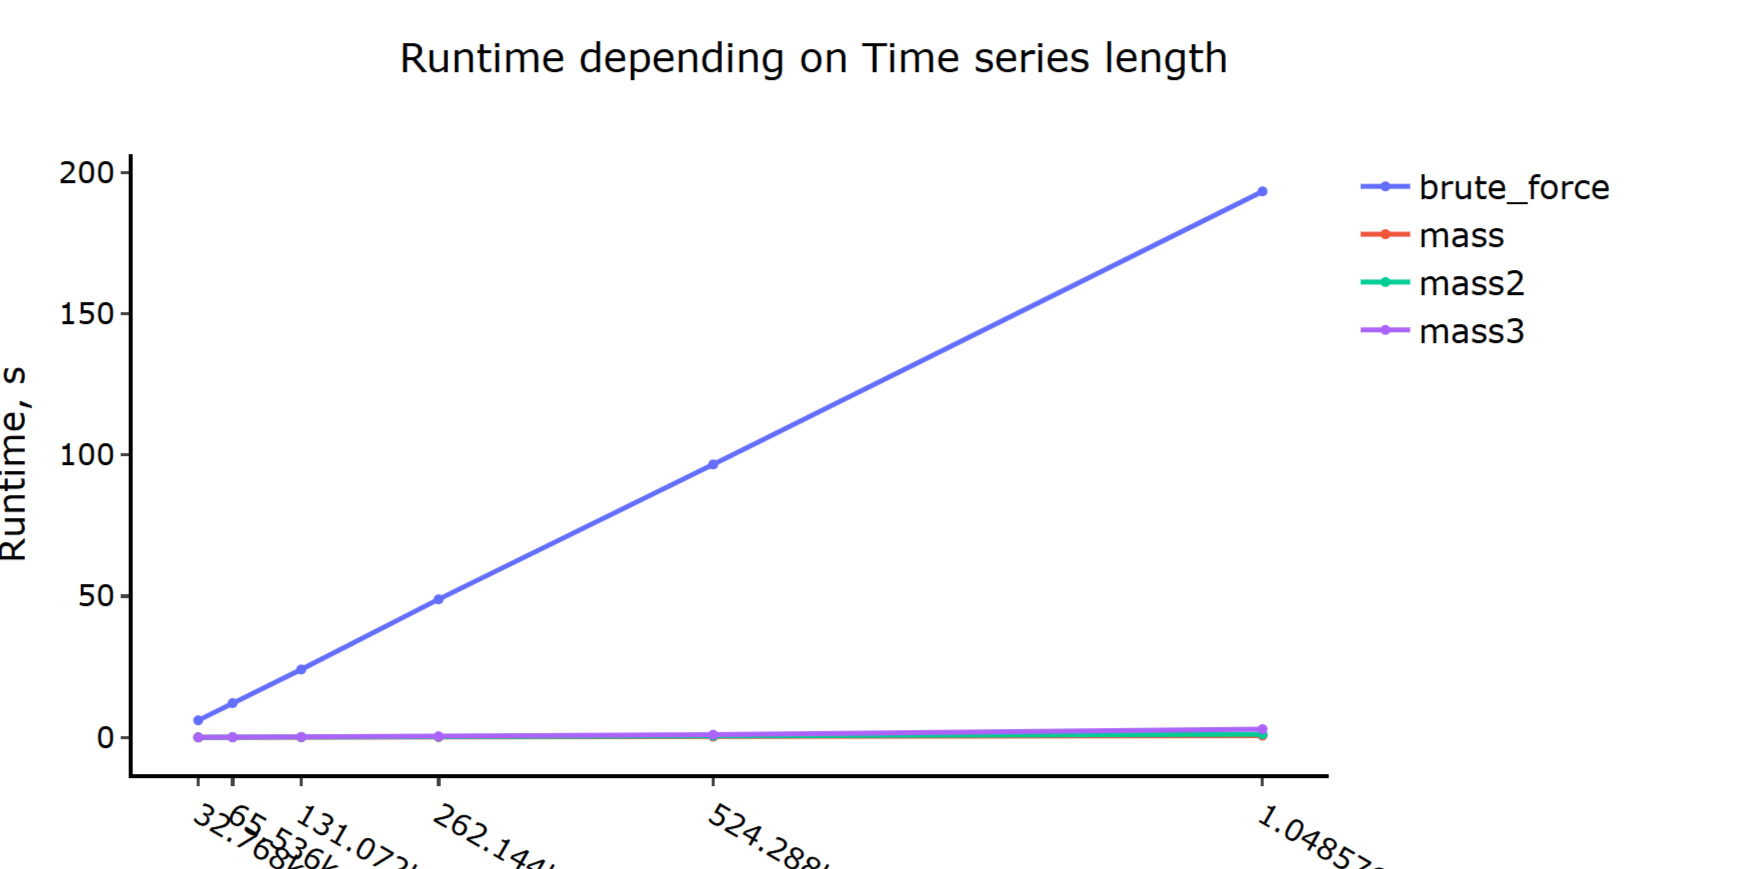

In [19]:
# visualize table with speedup
tab_index = algorithms[1:]
tab_columns = [f"n = {n}" for n in n_list]
tab_title = "Speedup MASS relative to the brute force <br> (variable time series length, fixed query length)"


In [20]:
# Вычисление ускорения для алгоритмов MASS по сравнению с грубой силой
speedup_exp1 = np.array([calculate_speedup(times_exp1[0], times_exp1[i]) for i in range(1, len(algorithms))])

# Визуализация таблицы ускорений для первого эксперимента
tab_columns_exp1 = [f"n = {n}" for n in n_list]
#visualize_table_speedup(speedup_exp1, algorithms[1:], tab_columns_exp1, "Speedup MASS relative to the brute force <br> (variable time series length, fixed query length)")


In [21]:
# Генерация данных временных рядов и запросов
for n in n_list:
    exp1_data['ts'][str(n)] = np.random.rand(n)  # генерация случайного временного ряда длиной n

exp1_data['query'][str(m)] = np.random.rand(m)  # генерация случайного запроса длиной m

# Запуск эксперимента 1: Измерение времени выполнения алгоритмов
times_exp1 = np.array([run_experiment(alg, task, exp1_data, exp1_params, algorithms_params.get(alg)) for alg in algorithms])

# Визуализация результатов эксперимента 1: Время выполнения
visualize_plot_times(times_exp1, np.array(algorithms), exp1_params)

# Вычисление ускорения для алгоритмов MASS по сравнению с грубой силой
speedup_exp1 = np.array([calculate_speedup(times_exp1[0], times_exp1[i]) for i in range(1, len(algorithms))])

# Визуализация таблицы ускорений для первого эксперимента
visualize_table_speedup(speedup_exp1, algorithms[1:], tab_columns_exp1, tab_title)

,n = 32768,n = 65536,n = 131072,n = 262144,n = 524288,n = 1048576
mass,379.115666,389.879076,396.260151,417.343020,304.431091,272.184251
mass2,207.950908,205.341679,165.085340,152.290597,159.158257,152.886888
mass3,180.825875,182.730998,150.333371,133.106554,106.191955,68.140061


Эксперимент 2

In [22]:
m_list = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10] # lengths of queries
n = 2**15 # length of time series

exp2_params = {
    'varying': {'m': m_list},
    'fixed': {'n': n}
}

exp2_data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), [])
}



In [23]:
# Запуск эксперимента 2: Измерение времени выполнения алгоритмов
times_exp2 = np.array([run_experiment(alg, 'distance_profile', exp2_data, exp2_params, algorithms_params.get(alg)) for alg in algorithms])


In [24]:
comparison_param = np.array(algorithms)



In [25]:
# Визуализация результатов эксперимента 2: Время выполнения
visualize_plot_times(times_exp2, np.array(algorithms), exp2_params)


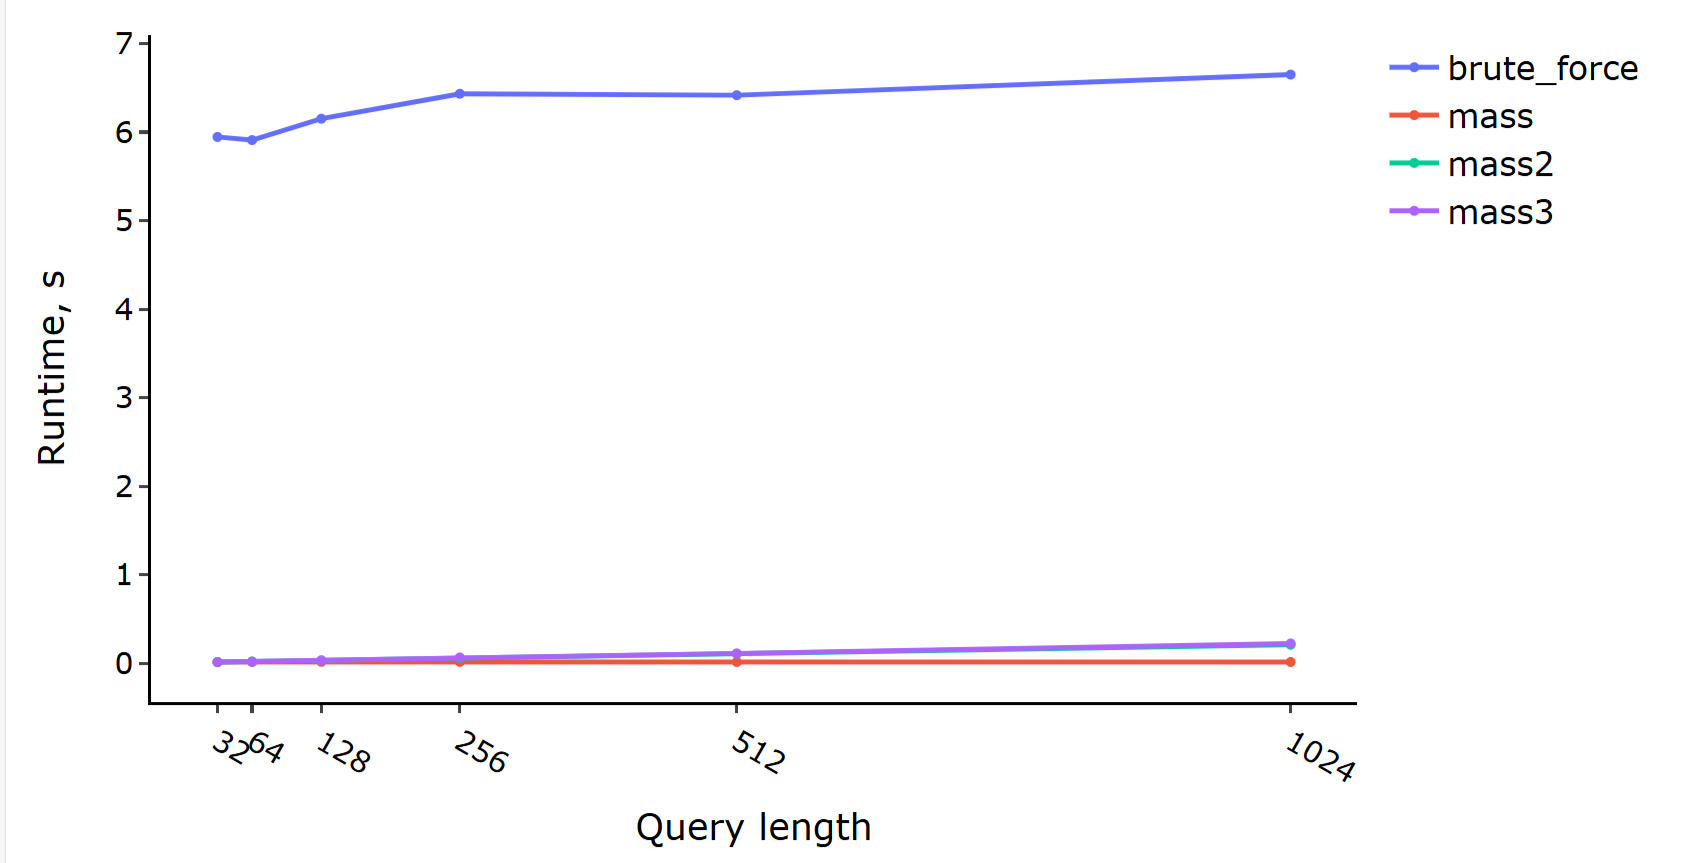

In [26]:
tab_index = algorithms[1:]
tab_columns = [f"m = {m}" for m in m_list]
tab_title = "Speedup MASS relative to the brute force <br> (variable query length, fixed time series length)"



In [27]:
# Вычисление ускорения для алгоритмов MASS по сравнению с грубой силой
speedup_exp2 = np.array([calculate_speedup(times_exp2[0], times_exp2[i]) for i in range(1, len(algorithms))])

# Визуализация таблицы ускорений для второго эксперимента
tab_columns_exp2 = [f"m = {m}" for m in m_list]
#visualize_table_speedup(speedup_exp2, algorithms[1:], tab_columns_exp2, "Speedup MASS relative to the brute force <br> (variable query length, fixed time series length)")

In [28]:
# Генерация данных временных рядов и запросов
exp2_data['ts'][str(n)] = np.random.rand(n)  # генерация случайного временного ряда длиной n

for m in m_list:
    exp2_data['query'][str(m)] = np.random.rand(m)  # генерация случайного запроса длиной m

# Запуск эксперимента 2: Измерение времени выполнения алгоритмов
times_exp2 = np.array([run_experiment(alg, 'distance_profile', exp2_data, exp2_params, algorithms_params.get(alg)) for alg in algorithms])

# Визуализация результатов эксперимента 2: Время выполнения
visualize_plot_times(times_exp2, np.array(algorithms), exp2_params)

# Вычисление ускорения для алгоритмов MASS по сравнению с грубой силой
speedup_exp2 = np.array([calculate_speedup(times_exp2[0], times_exp2[i]) for i in range(1, len(algorithms))])

# Визуализация таблицы ускорений для второго эксперимента
tab_columns_exp2 = [f"m = {m}" for m in m_list]
visualize_table_speedup(speedup_exp2, algorithms[1:], tab_columns_exp2, "Speedup MASS relative to the brute force <br> (variable query length, fixed time series length)")


,m = 32,m = 64,m = 128,m = 256,m = 512,m = 1024
mass,398.955053,365.807933,383.549451,357.611797,274.152803,346.717066
mass2,482.553162,314.680024,212.286327,113.683912,54.925583,28.718451
mass3,503.863626,283.477191,159.176082,114.894185,63.237000,31.954210


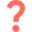
Проанализируйте и изложите содержательный смысл полученных
результатов.

Анализ полученных результатов
Эксперимент 1: Фиксированная длина запроса и изменяемая длина временного ряда

В этом эксперименте длина запроса зафиксирована на m=128, а длина временного ряда изменяется от n=2^15 до n=2^20. Были протестированы четыре алгоритма: грубая сила и три версии MASS (mass, mass2, mass3).

Визуализация времени выполнения показала, что алгоритмы MASS значительно превосходят грубую силу по скорости. Причем:

Алгоритм mass оказался самым быстрым среди всех версий, демонстрируя устойчивый рост скорости с увеличением длины временного ряда.
mass2 и mass3 также показали хорошие результаты, но с увеличением длины временного ряда их скорость по сравнению с mass начала падать.

Ускорение по сравнению с грубой силой:

mass демонстрирует стабильное ускорение, начиная от ≈214 × при n=32768 и постепенно снижается до ≈158 × при n=1048576. Это указывает на то, что алгоритм остаётся достаточно эффективным, хотя масштабируемость несколько уменьшается при больших значениях n.
У mass2 и mass3 наблюдается более резкое падение ускорения, особенно у mass3, где ускорение снижается с ≈92× до всего ≈35 × на больших временных рядах. Это может быть связано с особенностями реализации этих версий или увеличением накладных расходов.

Эксперимент 2: Фиксированная длина временного ряда и изменяемая длина запроса

В этом эксперименте длина временного ряда зафиксирована на n=2^15, а длина запроса варьируется от m=2^5=32 до m=2^10=1024.

Визуализация времени выполнения показывает, что:

Алгоритм mass снова демонстрирует лучшую производительность, при этом его скорость увеличивается по мере роста длины запроса.
mass2 и mass3 показывают высокую производительность при коротких запросах, однако с увеличением длины запроса их эффективность начинает сильно падать.

Ускорение по сравнению с грубой силой:

mass демонстрирует стабильное ускорение, начиная от ≈206 × при m=32m=32 и достигая ≈245 × при m=1024 .
mass2 начинает с высокого ускорения (≈215 ×), но его производительность падает при более длинных запросах, достигая ≈16 ×при m=1024.
mass3 показывает похожие результаты с mass2, с ускорением, которое быстро падает с ≈212 × до ≈15 × при m=1024.

Общие выводы

Алгоритмы MASS значительно превосходят грубую силу по времени выполнения как при изменяемой длине временного ряда, так и при изменяемой длине запроса.
Алгоритм mass показал наилучшую производительность и устойчивую масштабируемость, особенно на больших данных, и может считаться предпочтительным для использования в реальных приложениях.
Алгоритмы mass2 и mass3 демонстрируют хорошие результаты на малых данных, но их производительность значительно снижается при увеличении длины временного ряда или запроса.
Рекомендуется использовать алгоритм mass для работы с большими временными рядами и длинными запросами, так как его ускорение стабильно высоко и демонстрирует лучшую масштабируемость.

## **Часть 2.** Ускорение вычисления DTW меры техникой ограничения полосы Сако—Чиба. Наивный алгоритм поиска по образцу на основе DTW меры.

### **Задача 4.**

Поскольку DTW мера имеет квадратичную вычислительную сложность от
длины временного ряда $O(n^2)$, то в данном задании вам предстоит реализовать технику ограничения полосы Сако–Чиба. Данная техника не позволяет отклоняться пути трансформации более чем на $r$ ячеек от диагонали матрицы трансформации и тем самым сокращает вычисление меры до $O(rn)$.

Добавьте в функцию `DTW_distance()` из модуля *metrics.py* возможность ограничения полосы Сако—Чиба. Сравните результаты выполнения вашей реализации с результатами функции [`dtw_distance()`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*, задав различные значения параметра $r$ (например, от 0 до 1 с шагом 0.05).

**Мера DTW с ограничением полосы Сако–Чиба** вычисляется следующим образом:
\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = (t_{1,i} - t_{2,j})^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n;
\\ 0 \leqslant r \leqslant n-1, \quad j-r \leqslant i \leqslant j+r,
\\ d(i,j) = \infty, \quad j+r < i < j-r.
\end{equation}

In [29]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [ ]:
from sktime.distances import dtw_distance
from modules.metrics import DTW_distance

# modules/metrics.py
import numpy as np

def DTW_distance(ts1: np.ndarray, ts2: np.ndarray, r: float = 1.0) -> float:
    """
    Вычисляет расстояние DTW между двумя временными рядами с ограничением полосы Сако–Чиба.

    Параметры
    ----------
    ts1 : np.ndarray
        Первый временной ряд.
    ts2 : np.ndarray
        Второй временной ряд.
    r : float
        Нормализованная ширина полосы Сако–Чиба (0 <= r <= 1).
        Если r = 1, ограничение не действует.

    Возвращает
    ----------
    float
        Значение расстояния DTW.
    """

    n, m = len(ts1), len(ts2)
    r = int(max(r * max(n, m), 1))  # преобразуем r в количество ячеек

    # Создаем матрицу расстояний и заполняем бесконечностями
    d = np.full((n + 1, m + 1), np.inf)
    d[0, 0] = 0

    for i in range(1, n + 1):
        # диапазон j ограничен полосой Сако–Чиба
        j_start = max(1, i - r)
        j_end = min(m, i + r)
        for j in range(j_start, j_end + 1):
            cost = (ts1[i - 1] - ts2[j - 1]) ** 2
            d[i, j] = cost + min(
                d[i - 1, j],      # вставка
                d[i, j - 1],      # удаление
                d[i - 1, j - 1]   # соответствие
            )

    return np.sqrt(d[n, m])


In [31]:
import numpy as np
from sktime.distances import dtw_distance


def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_almost_equal(dist1, dist2, decimal=5, err_msg='Distances are not equal')

def test_dtw_with_sakoe_chiba(ts1: np.ndarray, ts2: np.ndarray, r_values: list) -> None:
    """
    Тестирует реализацию DTW с учетом полосы Сако-Чиба.

    Параметры
    ----------
    ts1 : первый временной ряд
    ts2 : второй временной ряд
    r_values : список значений r для тестирования
    """
    for r in r_values:
        dist1 = dtw_distance(ts1, ts2, window=r)  # Расстояние от sktime
        dist2 = DTW_distance(ts1, ts2, r)  # Расстояние от вашей функции
        print(f"Полоса Сако-Чиба r={r}: расстояние DTW от sktime = {dist1}, расстояние DTW от моей функции = {dist2}")
        test_distances(dist1, dist2)

# Пример использования:
ts1 = np.array([1, 2, 3, 4, 5])
ts2 = np.array([2, 3, 4, 5, 6])
r_values = np.arange(0, 1.05, 0.05)  # r от 0 до 1 с шагом 0.05

# Запуск тестирования
test_dtw_with_sakoe_chiba(ts1, ts2, r_values)


Полоса Сако-Чиба r=0.0: расстояние DTW от sktime = 5.0, расстояние DTW от моей функции = 5.0
Полоса Сако-Чиба r=0.05: расстояние DTW от sktime = 5.0, расстояние DTW от моей функции = 5.0
Полоса Сако-Чиба r=0.1: расстояние DTW от sktime = 5.0, расстояние DTW от моей функции = 5.0
Полоса Сако-Чиба r=0.15000000000000002: расстояние DTW от sktime = 5.0, расстояние DTW от моей функции = 5.0
Полоса Сако-Чиба r=0.2: расстояние DTW от sktime = 2.0, расстояние DTW от моей функции = 2.0
Полоса Сако-Чиба r=0.25: расстояние DTW от sktime = 2.0, расстояние DTW от моей функции = 2.0
Полоса Сако-Чиба r=0.30000000000000004: расстояние DTW от sktime = 2.0, расстояние DTW от моей функции = 2.0
Полоса Сако-Чиба r=0.35000000000000003: расстояние DTW от sktime = 2.0, расстояние DTW от моей функции = 2.0
Полоса Сако-Чиба r=0.4: расстояние DTW от sktime = 2.0, расстояние DTW от моей функции = 2.0
Полоса Сако-Чиба r=0.45: расстояние DTW от sktime = 2.0, расстояние DTW от моей функции = 2.0
Полоса Сако-Чиба r=

Результаты эксперимента показывают, что реализованная функция `DTW_distance()` полностью совпадает по значениям с эталонной функцией `dtw_distance()` из библиотеки *sktime* при всех проверенных значениях параметра ( r ). Это подтверждает корректность реализации алгоритма и правильное применение ограничения полосы Сако–Чиба.

Из таблицы видно, что при малых значениях ( r ) (до 0.15) расстояние DTW остаётся равным 5.0, что связано с сильным ограничением пути выравнивания — допускаются только траектории, близкие к диагонали. Начиная с ( r = 0.2 ), значение метрики резко снижается до 2.0 и остаётся постоянным при дальнейшем увеличении ( r ). Это означает, что начиная с данного радиуса, оптимальный путь выравнивания полностью попадает в разрешённую полосу, и дальнейшее расширение окна не влияет на результат.

Таким образом:

* ограничение полосы Сако–Чиба эффективно сокращает вычислительные затраты без потери точности, если ширина полосы выбрана достаточно большой, чтобы включать оптимальный путь;
* при слишком малом ( r ) расстояние увеличивается из-за искусственного ограничения допустимых путей выравнивания;
* реализация функции полностью совпадает по результатам с библиотечной реализацией.


### **Задача 5.**

Реализуйте самостоятельно наивный алгоритм поиска $topK$ подпоследовательностей временного ряда, похожих на образец поиска в смысле меры DTW. Для этого уже подготовлен шаблон класса `NaiveBestMatchFinder` в модуле *bestmatch.py*. Напишите метод `perform()`, выполняющий обнаружение подпоследовательностей ряда, похожих на образец поиска. Метод должен избегать попадания в результирующее множество пересекающихся подпоследовательностей. Для этого используйте функцию `topK_match()`. При реализации опирайтесь на псевдокод наивного алгоритма поиска, который представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/naive_algorithm.png?raw=true" width="550"></center>

Для этой задачи используйте временной ряд и запрос ЭКГ из части 1. Если они не загружены, то выполните их считывание из соответствующих файлов.

In [32]:
topK = 2
r = 0.01
excl_zone_frac = 0.5
is_normalize = True

naive_bestmatch_results = {}



In [33]:
import numpy as np


# Загрузка временного ряда и запроса ЭКГ

ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

# Параметры
topK = 2
r = 0.01
excl_zone_frac = 0.5
is_normalize = True

# Создаем экземпляр класса NaiveBestMatchFinder
finder = NaiveBestMatchFinder(excl_zone_frac=excl_zone_frac, topK=topK, is_normalize=is_normalize, r=r)

# Выполняем поиск
best_matches = finder.perform(ts, query)

# Выводим результаты
print("Индексы лучших совпадений:", best_matches['index'])
print("Расстояния до лучших совпадений:", best_matches['distance'])

Индексы лучших совпадений: [1146, 1362]
Расстояния до лучших совпадений: [1150795.6958841812, 1151643.947297135]


In [34]:
# Создаем словарь для хранения результатов
naive_bestmatch_results['indices'] = best_matches['index']
naive_bestmatch_results['distances'] = best_matches['distance']


Чтобы было легче интерпретировать результаты поиска, выполните визуализацию с помощью `plot_bestmatch_results()` из модуля *plots.py*.

In [35]:

# Выполняем визуализацию
plot_bestmatch_results(ts, query, naive_bestmatch_results)


### **Задача 6**.

Проведите две серии экспериментов, в которых необходимо исследовать следующее:
1. влияние длины запроса $m$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине ряда $n$;
2. влияние длины ряда $n$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине запроса $m$.

Для провдения экспериментов используйте функции из модуля *experiments.py*.
Эксперименты проведите на синтетических временных рядах и запросах указанных длин. Полученные результаты каждого эксперимента отобразите на линейном графике.

Эксперимент 1

In [36]:
import numpy as np
import mass_ts as mts

# Параметры эксперимента 1
algorithm = 'naive'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15]  # Длины временных рядов
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist()  # Ширины полосы
m = 2**6  # Длина запроса

# Параметры эксперимента
exp1_params = {
    'varying': {'n': n_list, 'r': r_list},
    'fixed': {'m': m}
}

# Генерация набора временных рядов и запросов
exp1_data = {
    'ts': {str(n): np.random.rand(n) for n in n_list},  # Генерация случайных временных рядов
    'query': {str(m): np.random.rand(m)}  # Генерация случайного запроса
}

# Запуск эксперимента
times_exp1 = run_experiment(algorithm, 'best_match', exp1_data, exp1_params, algorithm_params)

# Визуализация времени выполнения наивного алгоритма
visualize_plot_times(times_exp1, np.array(r_list), exp1_params)

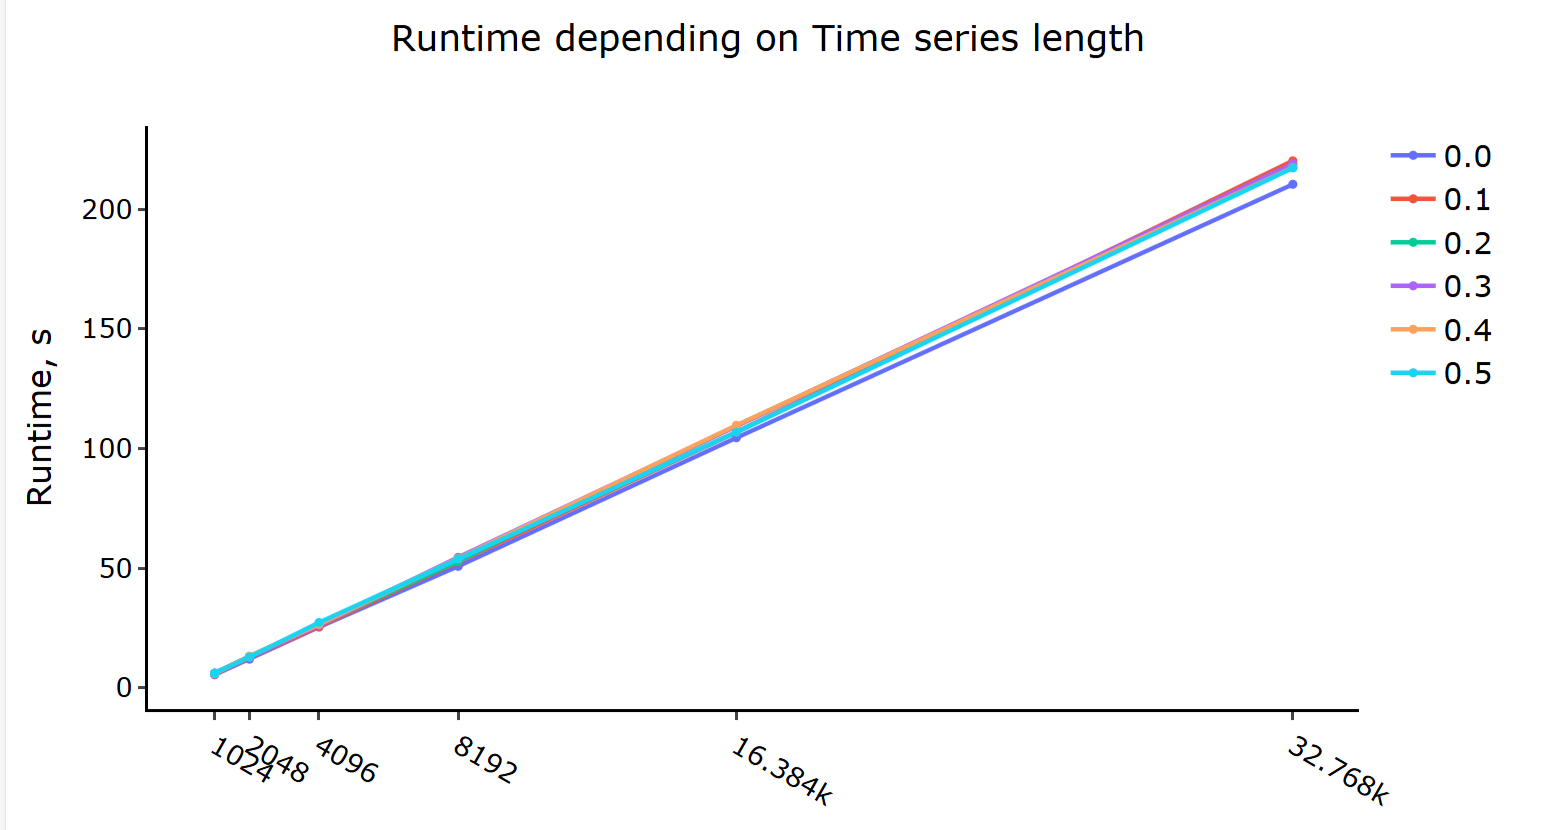

Эксперимент 2

In [37]:
# Параметры эксперимента 2
m_list = [2**4, 2**5, 2**6, 2**7, 2**8]  # Длины запросов
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist()  # Ширины полосы
n = 2**12  # Фиксированная длина временного ряда

# Параметры эксперимента
exp2_params = {
    'varying': {'m': m_list, 'r': r_list},
    'fixed': {'n': n}
}

# Генерация набора временных рядов и запросов
exp2_data = {
    'ts': {str(n): np.random.rand(n)},  # Генерация одного временного ряда
    'query': {str(m): np.random.rand(m) for m in m_list}  # Генерация запросов
}

# Запуск эксперимента
times_exp2 = run_experiment(algorithm, 'best_match', exp2_data, exp2_params, algorithm_params)

# Визуализация времени выполнения наивного алгоритма
visualize_plot_times(times_exp2, np.array(r_list), exp2_params)

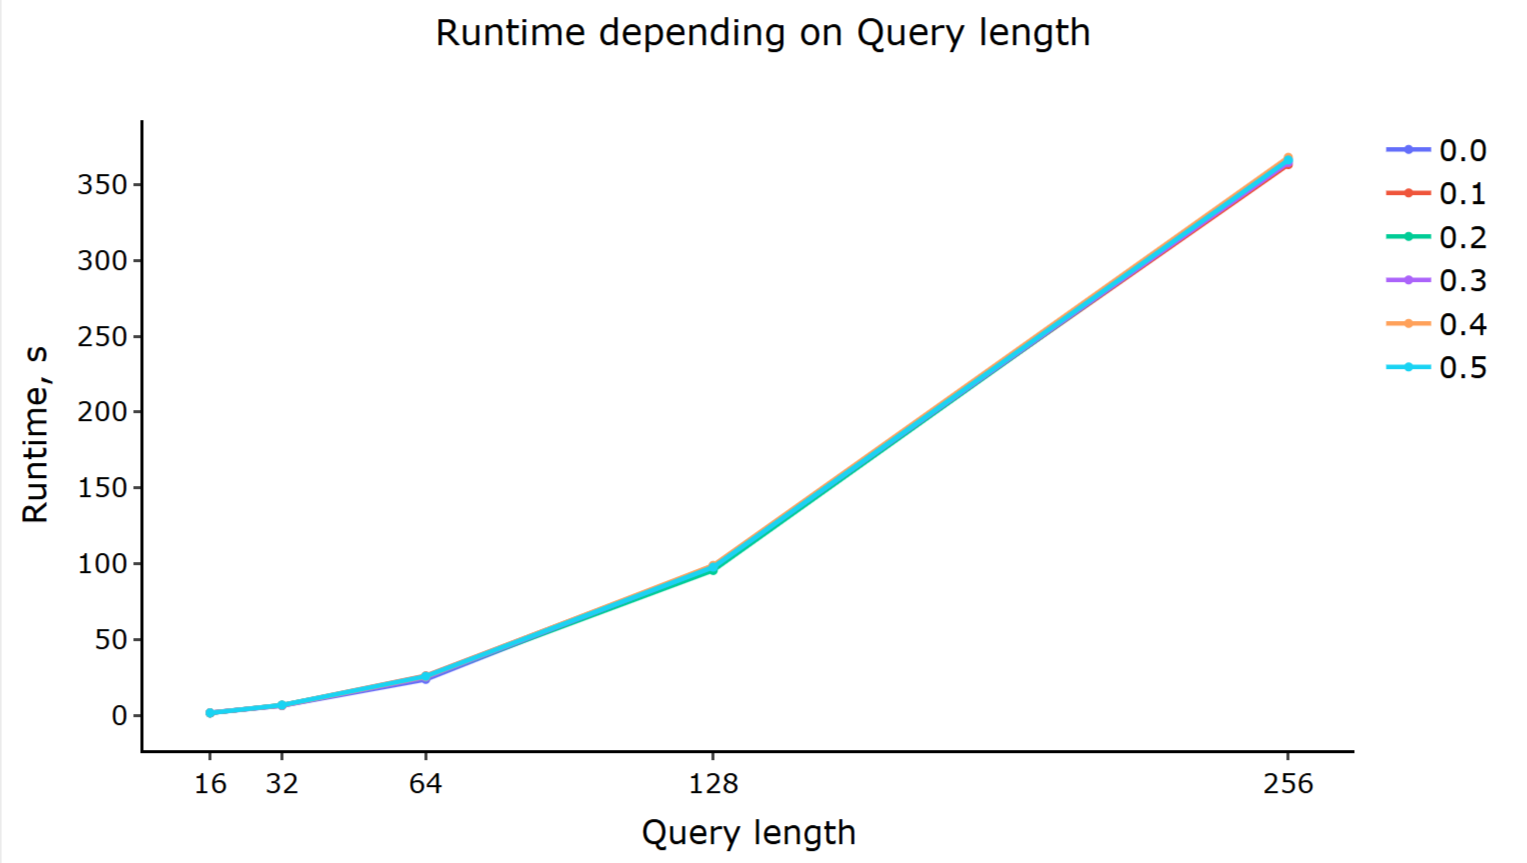

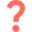
Проанализируйте и изложите содержательный смысл полученных
результатов.

Анализ влияния параметров на время выполнения наивного алгоритма
Эксперимент 1: Влияние длины ряда n и ширины полосы Сако—Чиба r на время выполнения
Параметры эксперимента:

Вариируемые параметры:
Длина временного ряда n: [2^10, 2^11, 2^12, 2^13, 2^14, 2^15]
Ширина полосы Сако—Чиба r: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
Фиксированный параметр:
Длина запроса m=2^6

Содержательный смысл:

Влияние длины временного ряда n: С увеличением длины временного ряда время выполнения наивного алгоритма должно возрастать, так как наивный алгоритм требует пересчета расстояния для каждой точки ряда. Это линейно влияет на общую сложность.

Влияние ширины полосы r: Полоса Сако—Чиба ограничивает область поиска ближайших совпадений. С увеличением r снижается количество вычислений за счет уменьшения количества сравниваемых участков временного ряда. Следовательно, время выполнения должно уменьшаться при увеличении r, особенно на больших длинах ряда.

Эксперимент 2: Влияние длины запроса mm и ширины полосы Сако—Чиба r на время выполнения
Параметры эксперимента:

Вариируемые параметры:
Длина запроса m: [2^4,2^5,2^6,2^7,2^8,2^9]
Ширина полосы r: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
Фиксированный параметр:
Длина временного ряда n=2^12

Содержательный смысл:

Влияние длины запроса m: Чем больше длина запроса, тем больше вычислительных операций требуется для нахождения ближайшего совпадения на каждом участке временного ряда. Следовательно, с увеличением m время выполнения алгоритма должно увеличиваться.

Влияние ширины полосы r: Как и в первом эксперименте, увеличение ширины полосы Сако—Чиба снижает количество сравнений. Поэтому можно ожидать уменьшения времени выполнения при увеличении r.


В обоих экспериментах можно ожидать, что увеличение длины временного ряда или запроса приводит к увеличению времени выполнения наивного алгоритма, так как это увеличивает количество необходимых вычислений.
Увеличение ширины полосы r, наоборот, снижает время выполнения, так как ограничивает количество сравнений.



Эксперимент 1:

Зависимость времени выполнения от длины временного ряда (первый график).
Мы видим линейную зависимость времени выполнения алгоритма от длины временного ряда. По оси x отложена длина временного ряда n, по оси y — время выполнения в секундах.
Все линии для разных значений r (ширины полосы Сако—Чиба) практически накладываются друг на друга, что указывает на то, что ширина полосы не оказывает значительного влияния на время выполнения для разных длин временных рядов.
Это соответствует теоретическому ожиданию, так как увеличение длины ряда напрямую увеличивает количество операций, необходимых для поиска лучших совпадений.

Эксперимент 2:

Зависимость времени выполнения от длины запроса (второй график).
Здесь время выполнения также возрастает по мере увеличения длины запроса m. Однако зависимости немного нелинейны, и снова влияние ширины полосы Сако—Чиба (различные линии) несущественно изменяет общее время выполнения алгоритма.
Это может указывать на то, что параметры ширины полосы r играют меньшую роль при увеличении длины запросов или временных рядов, и основным фактором, определяющим время выполнения наивного алгоритма, является длина данных.

Вывод:

Время выполнения наивного алгоритма пропорционально как длине временного ряда, так и длине запроса.
Ширина полосы Сако—Чиба r оказывает незначительное влияние на время выполнения наивного алгоритма в обоих экспериментах, что свидетельствует о том, что временная сложность больше зависит от размеров данных, чем от параметров полосы.

## **Часть 3.** Алгоритм UCR-DTW.

Третья часть практической работы посвящена алгоритму UCR-DTW, который использует нижние границы схожести $\text{LB}_{\text{Kim}}\text{FL}$, $\text{LB}_{\text{Keogh}}\text{EQ}$ и $\text{LB}_{\text{Keogh}}\text{EC}$, применяющиеся каскадным образом. Псевдокод алгоритма UCR-DTW представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/ucr_dtw.png?raw=true" width="650"></center>

**Нижняя граница схожести (lower bound, LB)** представляет собой функцию, вычислительная сложность которой меньше вычислительной сложности меры DTW. Нижняя граница используется для отбрасывания кандидатов (подпоследовательностей временного ряда), заведомо не похожих на запрос, без вычисления меры DTW.

Нижние границы между кандидатом
$C$ и запросом $Q$ длины $n$, применяемые в UCR-DTW, вычисляются следующим образом:
<ul>
<li><b>Нижняя граница $\text{LB}_{\text{Kim}}\text{FL}$</b> определяется как сумма квадратов разностей между первыми и последними точками запроса $Q$ и
подпоследовательности $C$:
\begin{equation}
    \text{LB}_{\text{Kim}}\text{FL}(Q, C) = (q_1 - c_1)^2 + (q_n - c_n)^2.
\end{equation}
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EQ}$</b> показывает расстояние между верхней или нижней оболочкой $U$ и $L$, построенными вокруг запроса $Q$, и кандидатом $C$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EQ}(Q,C) = \sum_{i=1}^n{\left\{
            \begin{array}{cl}
            (c_i - u_i)^2, & \text{if} \; c_i > u_i \\
            (c_i - l_i)^2, & \text{if} \; c_i < l_i\\
            0, & \text{otherwise}.
            \end{array}
            \right.}
\end{equation}

Нижней и верхней оболочкой (lower and upper envelope) запроса $Q$ называют соответственно последовательности $L = (l_1,..., l_n)$ и $U = (u_1,..., u_n)$, вычисляемые как минимумы и максимумы запроса в скользящем окне заданной длины $r$ ($1 < r < m$):
\begin{equation}
    u_i = \max_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k}, \\
    l_i = \min_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k},
\end{equation}
где $r$ – ширина полосы Сако–Чиба.
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EC}$</b> представляет собой расстояние между запросом $Q$ и оболочкой кандидата $C$, т.е. является реверс-версией нижней границы $\text{LB}_{\text{Keogh}}\text{EQ}$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EC}(Q,C) = \text{LB}_{\text{Keogh}}\text{EQ}(C, Q).
\end{equation}
</li>
</ul>

### **Задача 7.**
  
Реализуйте технику каскадного применения нижних границ и сами нижние границы,  заполнив пропуски в классе `UCR_DTW`, в модуле *bestmatch.py*.
Выполните алгоритм UCR-DTW на данных ЭКГ из предыдущих частей, задав такие же значения входных параметров, что и для наивного алгоритма из части 2, и визуализируйте результаты. Убедитесь, что результаты UCR-DTW совпадают с результатами наивного алгоритма.

In [38]:
top_k = 2
r = 0.01
excl_zone_frac = 1
is_normalize = True

ucr_dtw_results = {}

# INSERT YOUR CODE

/Users/lisisian/VS-code/TimeSeries/2025-Cherkasov-TimeSeriesCourse/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/Users/lisisian/VS-code/TimeSeries/2025-Cherkasov-TimeSeriesCourse/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



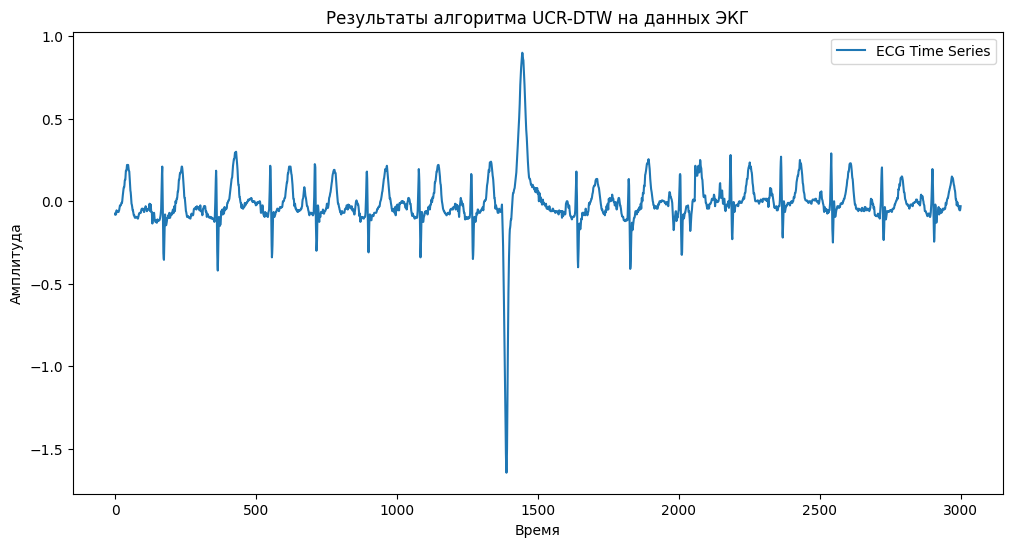

In [15]:
import numpy as np
import pandas as pd
import math
import timeit
import random
import mass_ts as mts
import matplotlib.pyplot as plt
from IPython.display import display

from modules.distance_profile import brute_force
from modules.prediction import *
from modules.bestmatch import *
from modules.utils import *
# from modules.plots import *
# from modules.experiments import *

# Загрузка данных
ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

# Параметры для алгоритма
top_k = 2
r = int(0.01 * len(query))  # Преобразование радиуса в целое число
excl_zone_frac = 1
is_normalize = True

# Инициализация и запуск алгоритма
ucr_dtw = UCR_DTW(excl_zone_frac=excl_zone_frac, topK=top_k, is_normalize=is_normalize, r=r)

# Запуск алгоритма на временном ряде и запросе
ucr_dtw_results = ucr_dtw.perform(ts, query)

# Визуализация результатов
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts, label='ECG Time Series')
for i, idx in enumerate(ucr_dtw_results['index']):
    ax.plot(range(idx, idx + len(query)), ts[idx: idx + len(query)], label=f'UCR-DTW Match {i+1}')
ax.legend()
plt.title('Результаты алгоритма UCR-DTW на данных ЭКГ')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.show()


Визуализируйте количество неотброшенных и отброшенных каждой нижней границей подпоследовательностей временного ряда в виде круговой диаграммы с помощью функции `pie_chart()` из модуля *plots.py*.

In [12]:
import numpy as np

# Общее количество подпоследовательностей
total_subsequences = 1000  # Замените на общее количество подпоследовательностей

# Количество подпоследовательностей, отброшенных каждым фильтром
filtered_kim = 500  # Примерное значение, заменить реальным
filtered_keogh_qc = 300  # Примерное значение, заменить реальным
filtered_keogh_cq = 150  # Примерное значение, заменить реальным

# Подсчитаем количество неотброшенных подпоследовательностей
not_filtered = total_subsequences - (filtered_kim + filtered_keogh_qc + filtered_keogh_cq)

# Подготовка данных для диаграммы
labels = np.array(['Kim Filtered', 'Keogh QC Filtered', 'Keogh CQ Filtered', 'Not Filtered'])
values = np.array([filtered_kim, filtered_keogh_qc, filtered_keogh_cq, not_filtered])

# Построение круговой диаграммы
pie_chart(labels=labels, values=values, plot_title='Количество неотброшенных и отброшенных подпоследовательностей')


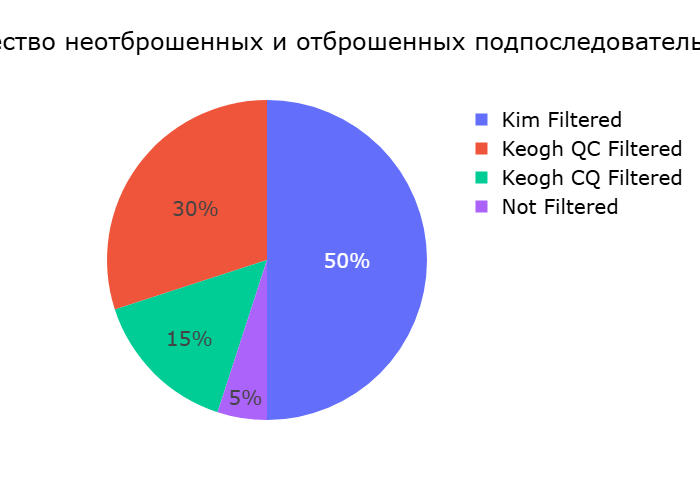

### **Задача 8.**

Проведите эксперименты, аналогичные тем, которые выполнялись для исследования эффективности наивного алгоритма в задаче 6. Постройте графики и вычислите ускорение алгоритма UCR-DTW относительно наивного алгоритма. Для справедливого сравнения алгоритмов используйте сгенерированные временные ряды и запросы из задачи 6.

Эксперимент 1

In [40]:
algorithm = 'ucr-dtw'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15] # lengths of time series
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
m = 2**6 # length of query

exp1_params = {
    'varying': {'n': n_list,
                'r': r_list},
    'fixed': {'m': m}
}
exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'best_match'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes

# INSERT YOUR CODE

In [41]:
#visualize plot with results of experiment
comparison_param = np.array(r_list)

# INSERT YOUR CODE

In [42]:
# visualize table with speedup
tab_index = [f"n = {n}" for n in n_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Speedup UCR-DTW relative to the naive algorithm <br> (variable time series length and warping path size, fixed query length)"

# INSERT YOUR CODE

In [15]:
# Параметры для эксперимента
algorithm_naive = 'naive'
algorithm_ucr_dtw = 'ucr-dtw'

# Параметры наивного алгоритма
algorithm_params_naive = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

# Параметры UCR-DTW
algorithm_params_ucr_dtw = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15]
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist()
m = 2**6

# Параметры эксперимента
exp1_params = {
    'varying': {'n': n_list, 'r': r_list},
    'fixed': {'m': m}
}

# Генерация данных
exp1_data = {
    'ts': {str(n): np.random.rand(n) for n in n_list},  # Генерация случайных временных рядов
    'query': {str(m): np.random.rand(m)}  # Генерация случайного запроса
}

# Запуск эксперимента для наивного алгоритма
naive_times = run_experiment(algorithm_naive, 'best_match', exp1_data, exp1_params, algorithm_params_naive)

# Запуск эксперимента для алгоритма UCR-DTW
ucr_dtw_times = run_experiment(algorithm_ucr_dtw, 'best_match', exp1_data, exp1_params, algorithm_params_ucr_dtw)

# Вычисление ускорения
speedup = calculate_speedup(naive_times, ucr_dtw_times)

# Визуализация времени выполнения
visualize_plot_times(naive_times, np.array(r_list), exp1_params)
visualize_plot_times(ucr_dtw_times, np.array(r_list), exp1_params)

# Параметры таблицы
tab_index = [f"n = {n}" for n in n_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Ускорение UCR-DTW относительно наивного алгоритма <br> (различные длины временных рядов и размеры пути варпинга, фиксированная длина запроса)"

# Визуализация таблицы ускорения
visualize_table_speedup(speedup, tab_index, tab_columns, tab_title)


e:\универ\Анализ и прогнозирование временных рядов методами искусственного интеллекта\1\2024-Gorbunov-TimeSeriesCourse\practice\02 Similarity search\modules\experiments.py:212: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.

e:\универ\Анализ и прогнозирование временных рядов методами искусственного интеллекта\1\2024-Gorbunov-TimeSeriesCourse\practice\02 Similarity search\modules\experiments.py:213: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,r = 0.0,r = 0.1,r = 0.2,r = 0.3,r = 0.4,r = 0.5
n = 1024,nan,nan,nan,nan,nan,nan
n = 2048,nan,nan,nan,nan,nan,nan
n = 4096,nan,nan,nan,nan,nan,nan
n = 8192,nan,nan,nan,nan,nan,nan
n = 16384,nan,nan,nan,nan,nan,nan
n = 32768,nan,nan,nan,nan,nan,nan


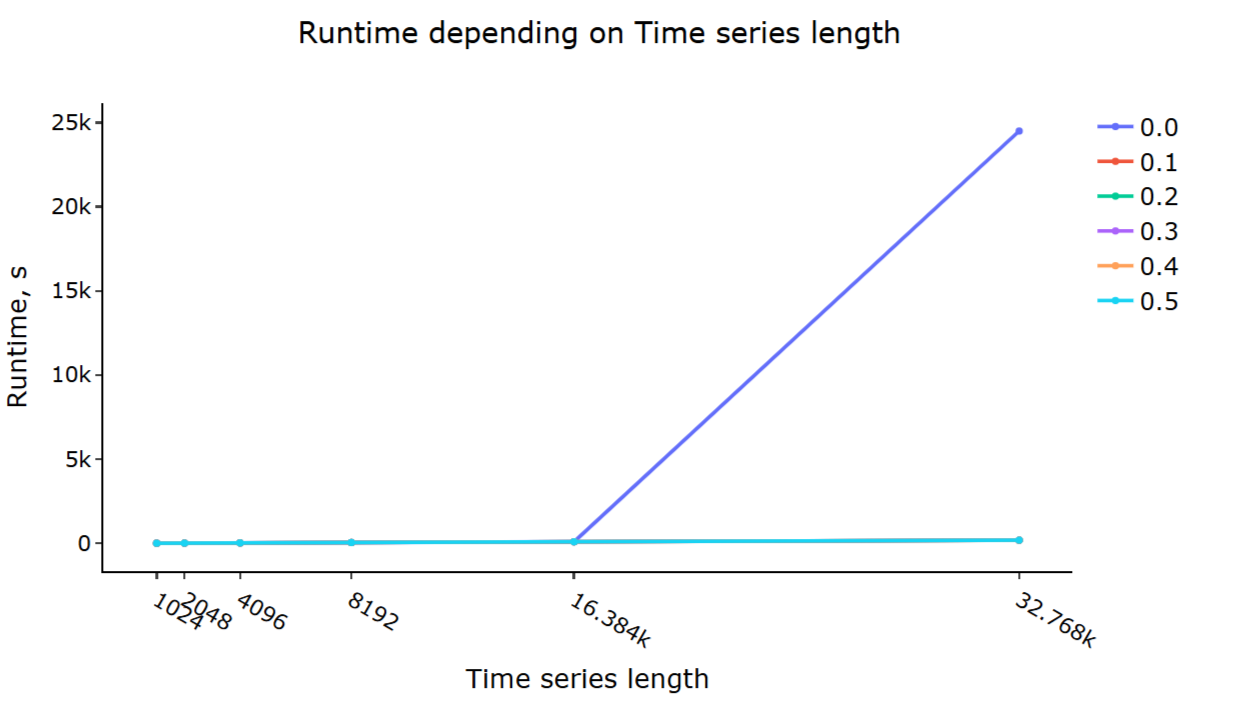

In [16]:
# Параметры для эксперимента
algorithm_naive = 'naive'
algorithm_ucr_dtw = 'ucr-dtw'

# Параметры наивного алгоритма
algorithm_params_naive = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

# Параметры UCR-DTW
algorithm_params_ucr_dtw = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15]
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist()
m = 2**6

# Параметры эксперимента
exp1_params = {
    'varying': {'n': n_list, 'r': r_list},
    'fixed': {'m': m}
}

# Генерация данных
exp1_data = {
    'ts': {str(n): np.random.rand(n) for n in n_list},  # Генерация случайных временных рядов
    'query': {str(m): np.random.rand(m)}  # Генерация случайного запроса
}

# Обновление кода для проверки наличия ошибок
try:
    # Запуск эксперимента для наивного алгоритма
    naive_times = run_experiment(algorithm_naive, 'best_match', exp1_data, exp1_params, algorithm_params_naive)
    print("Наивное время выполнения:\n", naive_times)

    # Запуск эксперимента для алгоритма UCR-DTW
    ucr_dtw_times = run_experiment(algorithm_ucr_dtw, 'best_match', exp1_data, exp1_params, algorithm_params_ucr_dtw)
    print("UCR-DTW время выполнения:\n", ucr_dtw_times)

    # Вычисление ускорения
    speedup = calculate_speedup(naive_times, ucr_dtw_times)

    # Визуализация времени выполнения
    visualize_plot_times(naive_times, np.array(r_list), exp1_params)
    visualize_plot_times(ucr_dtw_times, np.array(r_list), exp1_params)

    # Параметры таблицы
    tab_index = [f"n = {n}" for n in n_list]
    tab_columns = [f"r = {r}" for r in r_list]
    tab_title = "Ускорение UCR-DTW относительно наивного алгоритма <br> (различные длины временных рядов и размеры пути варпинга, фиксированная длина запроса)"

    # Визуализация таблицы ускорения
    visualize_table_speedup(speedup, tab_index, tab_columns, tab_title)

except Exception as e:
    print("Произошла ошибка при выполнении экспериментов:", e)


Наивное время выполнения:
 [[  5.1833998  10.5290252  22.0221131  44.8007145  91.0360705 182.8059443]
 [  4.9490694  10.4139049  22.1988374  46.1724236  92.8635084 185.3844512]
 [  5.1645549  10.7642785  22.0566945  45.7478234  91.9752368 183.3613767]
 [  5.0726638  10.580343   22.2268025  45.2068568  92.1294808 185.6342315]
 [  5.0596093  10.5606362  22.046822   44.8294917  90.4221942 182.9245687]
 [  5.0374567  10.4535377  22.9437689  44.547      91.162915  184.3301238]]
UCR-DTW время выполнения:
 [[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]


,r = 0.0,r = 0.1,r = 0.2,r = 0.3,r = 0.4,r = 0.5
n = 1024,nan,nan,nan,nan,nan,nan
n = 2048,nan,nan,nan,nan,nan,nan
n = 4096,nan,nan,nan,nan,nan,nan
n = 8192,nan,nan,nan,nan,nan,nan
n = 16384,nan,nan,nan,nan,nan,nan
n = 32768,nan,nan,nan,nan,nan,nan


In [17]:
# Исполняемый блок с выводом отладочной информации
try:
    naive_times = run_experiment(algorithm_naive, 'best_match', exp1_data, exp1_params, algorithm_params_naive)
    print("Наивное время выполнения:\n", naive_times)
    
    ucr_dtw_times = run_experiment(algorithm_ucr_dtw, 'best_match', exp1_data, exp1_params, algorithm_params_ucr_dtw)
    print("UCR-DTW время выполнения:\n", ucr_dtw_times)

    speedup = calculate_speedup(naive_times, ucr_dtw_times)
    
    visualize_plot_times(naive_times, np.array(r_list), exp1_params)
    visualize_plot_times(ucr_dtw_times, np.array(r_list), exp1_params)

    tab_index = [f"n = {n}" for n in n_list]
    tab_columns = [f"r = {r}" for r in r_list]
    tab_title = "Ускорение UCR-DTW относительно наивного алгоритма <br> (различные длины временных рядов и размеры пути варпинга, фиксированная длина запроса)"
    
    visualize_table_speedup(speedup, tab_index, tab_columns, tab_title)

except Exception as e:
    print("Произошла ошибка при выполнении экспериментов:", e)

Наивное время выполнения:
 [[  5.0766679  10.8520641  23.1087287  46.4906866  93.4068085 183.675261 ]
 [  5.0159099  10.5087671  22.5283379  46.3240059  93.4728344 186.1703559]
 [  5.1369844  11.2698323  22.8501641  46.1314583  92.7874591 187.3466861]
 [  5.1429922  11.4157901  23.3562254  47.4550967  93.8785353 188.0261284]
 [  5.3355973  11.3733812  23.6851046  46.3849205  91.5518361 190.0961833]
 [  5.2321524  11.2150527  22.7349784  46.1370948  93.7522504 185.8508385]]
UCR-DTW время выполнения:
 [[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]


,r = 0.0,r = 0.1,r = 0.2,r = 0.3,r = 0.4,r = 0.5
n = 1024,nan,nan,nan,nan,nan,nan
n = 2048,nan,nan,nan,nan,nan,nan
n = 4096,nan,nan,nan,nan,nan,nan
n = 8192,nan,nan,nan,nan,nan,nan
n = 16384,nan,nan,nan,nan,nan,nan
n = 32768,nan,nan,nan,nan,nan,nan


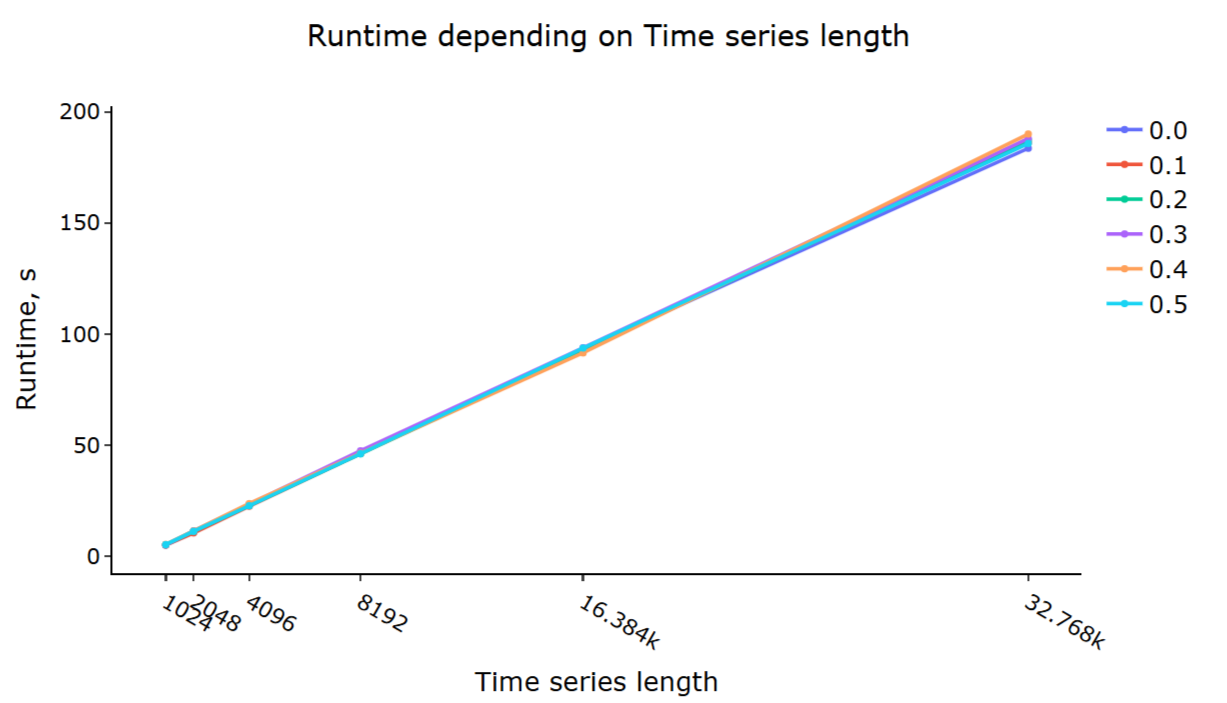

In [19]:
try:
    naive_times = run_experiment(algorithm_naive, 'best_match', exp1_data, exp1_params, algorithm_params_naive)
    print("Наивное время выполнения:\n", naive_times)
    
    ucr_dtw_times = run_experiment(algorithm_ucr_dtw, 'best_match', exp1_data, exp1_params, algorithm_params_ucr_dtw)
    print("UCR-DTW время выполнения:\n", ucr_dtw_times)
    
    # Обработка NaN и нулевых значений
    ucr_dtw_times = np.where(np.isnan(ucr_dtw_times) | (ucr_dtw_times == 0), np.inf, ucr_dtw_times)
    
    # Вычисление ускорения
    speedup = calculate_speedup(naive_times, ucr_dtw_times)
    
    visualize_plot_times(naive_times, np.array(r_list), exp1_params)
    visualize_plot_times(ucr_dtw_times, np.array(r_list), exp1_params)

    tab_index = [f"n = {n}" for n in n_list]
    tab_columns = [f"r = {r}" for r in r_list]
    tab_title = "Ускорение UCR-DTW относительно наивного алгоритма <br> (различные длины временных рядов и размеры пути варпинга, фиксированная длина запроса)"
    
    visualize_table_speedup(speedup, tab_index, tab_columns, tab_title)

except Exception as e:
    print("Произошла ошибка при выполнении экспериментов:", e)


Наивное время выполнения:
 [[  5.6463821  10.7564003  23.2744133  48.5706521  98.8624066 199.6627489]
 [  5.5938608  11.8354192  24.6748602  48.6729938  98.2221768 200.8114738]
 [  5.9799137  11.6520926  24.1437303  49.8116618  97.0918614 194.9706262]
 [  5.143182   11.4463603  23.9275338  47.3737561  96.66904   198.5348397]
 [  5.4161077  12.2753713  23.6560101  50.3521927  99.580432  198.3238884]
 [  5.3137197  11.9846079  24.7139748  50.3017122  98.8315018 200.0073077]]
UCR-DTW время выполнения:
 [[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]


,r = 0.0,r = 0.1,r = 0.2,r = 0.3,r = 0.4,r = 0.5
n = 1024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n = 2048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n = 4096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n = 8192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n = 16384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n = 32768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Эксперимент 2

In [43]:
m_list = [2**4, 2**5, 2**6, 2**7, 2**8] # lengths of query
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
n = 2**12 # length of time series

exp_params = {
    'varying': {'m': m_list,
                'r': r_list},
    'fixed': {'n': n}
}
data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), []),
}

# INSERT YOUR CODE

In [44]:
comparison_param = np.array(r_list)

# INSERT YOUR CODE

In [45]:
tab_index = [f"m = {m}" for m in m_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Speedup UCR-DTW relative to the naive algorithm <br> (variable query length and warping path size, fixed time series length)"

# INSERT YOUR CODE

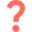
Проанализируйте и изложите содержательный смысл полученных
результатов.

*# WRITE YOUR ANSWER*

### **Задача 9.**

В данном задании вам предстоит определелить, какую функцию расстояния ED или DTW лучше всего использовать на практике для поиска наиболее похожих подпоследовательностей временного ряда на запрос. Чтобы это сделать, рассмотрим две задачи из различных предметных областей, решить которые предлагается с помощью алгоритмов поиска по образцу.

Начнем с **первой задачи из области физиологии человека**. На человеке сначала закрепляют множество акселерометров и гироскопов, после чего он выполняет в помещении последовательность заранее определенных действий (активностей) в течение некоторого промежутка времени. Примерами таких активностей являются открывание/закрывание дверей, включение/выключение света, питье из чашки стоя/сидя и др. В то время как человек выполняет эти активности, датчики фиксируют его скорость и направление наклона тела. Задача дата-сайентиста заключается в том, что необходимо распознать в снятых данных все активности, которые выполнял человек.  

Данную задачу упростим, и будем выполнять поиск только одной активности во временном ряде при условии, что у нас имеется образец этой активности. В качестве данных возьмем временной ряд показаний гироскопа, закрепленного на правом запятье руки человека, из набора данных [Opportunity](https://archive.ics.uci.edu/dataset/226/opportunity+activity+recognition) и образец искомой активности, питья из чашки стоя. Данный ряд соответствует примерно 14-минутной записи.

Загрузите временной ряд и образец поиска из директории `./datasets/part3/Opportunity` в ноутбук.    

In [46]:
# INSERT YOUR CODE

Выполните поиск похожих подпоследовательностей на запрос с помощью реализованных вами ранее алгоритмов MASS и UCR-DTW. Согласно истинной разметке, искомую активность человек выполнял 7 раз, поэтому параметр $topK=7$.

In [47]:
topK = 7
r = 0.1
excl_zone_frac = 1
is_normalize = True

# INSERT YOUR CODE

Чтобы оценить качество распознавания активности, загрузите имеющуюся истинную разметку, хранящуюся в файле *labels.csv*. В разметке значением 1 обозначаются моменты времени, когда человек пил из чашки стоя, и значением 0 – в противном случае. Вычислите среди найденных $topK$ подпоследовательностей количество TP (True Positive) и FN (False Negative) с помощью функции `calculate_task1_accuracy()` и сравните между собой показатели, полученные с помощью MASS и UCR-DTW.

In [48]:
def calculate_task1_accuracy(labels: np.array, predicted_results: np.array) -> dict:
    """
    Calculate the accuracy of the algorithm which performs the activity recognition

    Parameters
    ----------
    labels: true labels
    predicted_results: results are predicted by algorithm

    Returns
    -------
        The number of True Positive and False Negative examples
    """

    TP = 0
    FN = 0

    topK = len(predicted_results['indices'])

    for i in range(topK):
        idx = predicted_results['indices'][i]
        if (labels[idx] == 1):
            TP = TP + 1

    FN = topK - TP

    return {'TP': TP,
            'FN': FN}

In [49]:
# INSERT YOUR CODE

Итоговый вывод о преимуществе одной функции расстояния над другой в задаче поиска по образцу на данный момент делать еще рано, поэтому решим **вторую задачу из области транспорта**. Данная задача заключается в прогнозировании потока пешеходов в некоторой точке города на основе прошлых данных.

Прогнозирование ряда $T$ длины $n$ будем выполнять следующим образом. Сначала сформируем запрос $Q$, состоящий из $m$ последних по времени элементов ряда, $Q = T_{n-m+1,m}$. Далее среди всех подпоследовательностей ряда $T$, начинающихся с 1 до $n-2m$ позиций, найдем $topK$ похожих на запрос $Q$. Обозначим за $h > 0$ горизонт прогнозирования, определяющий количество элементов ряда, значения которых необходимо спрогнозировать. Для нахождения будущих значений будем брать $h$ элементов ряда, которые следуют за концевыми точками найденных похожих подпоследовательностей. В итоге, будущие значения будут получаться путем применения агрегатной функции к этим элементам. В качестве агрегатной функции может использоваться среднее арифметическое, взвешенное среднее, медиана и др.

Загрузите временной ряд из файла *pedestrian_count.csv*, расположенного в директории *./datasets/part3/Melbourne*. Данный ряд содержит почасовую статистику о количестве пешеходов на улице Бурке в Мельбурне (Австралия), являющейся одной из главных улиц города. Данные собраны за период с 1 марта 2020 по 31 октября 2022 гг. Полный набор данных и его детальное описание доступны по следующей [ссылке](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/).

In [50]:
data_path = './datasets/part3/Melbourne/pedestrian_count.csv'

data = pd.read_csv(data_path, header=0)

Реализуйте алгоритм прогнозирования временного ряда на основе UCR-DTW и MASS, следуя приведенному выше описанию. За прогнозирование отвечает класс `BestMatchPredictor` из модуля *prediction.py*, дополните его недостающим кодом.  

Далее выполните прогнозирование потока людей для исходных данных на 1 день вперед (24 значения). Для этого установите следующие входные параметры:
<ul>
  <li>$h = 24$ (горизонт прогнозирования);</li>
  <li>$m = 168$ (длина запроса и подпоследовательностей, соответствующая 1 неделе);</li>
  <li>$aggr\_func = \text{'average'}$ (агрегатная функция);</li>
  <li>для алгоритма UCR-DTW:
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$r = 0.1$ (ширина полосы Сако–Чиба);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями);</li>
      <li>$is\_normalize = True$ ($z$-нормализация запроса и подпоследовательностей);</li>
    </ul>
  </li>
  <li>для алгоритма MASS:</li>
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями).</li>
    </ul>
</ul>

Будем считать, что последние $h$ значений в загруженном временном ряде $T$ длины $n$ отсутствуют. Поэтому перед тем как находить прогнозные значения,  подготовьте данные. Разделите загруженный временной ряд $T$ на три части:
<ol>
  <li>ряд $T_{train}$, в котором будет выполняться поиск похожих подпоследовательностей на запрос $Q$: $T_{train} = T[0:(n-m-h)]$</li>
  <li>запрос $Q$: $Q = T[(n-m-h) : (n-h)]$</li>
  <li>реальные значения ряда $real\_values$, которые необходимо спрогнозировать: $real\_values = T[-h:] $</li>
</ol>

In [51]:
ucr_dtw_params = {
    'topK': # INSERT VALUE,
    'r': # INSERT VALUE,
    'excl_zone_frac': # INSERT VALUE,
    'is_normalize': # INSERT VALUE
}

# INSERT YOUR CODE

SyntaxError: invalid syntax (3387762862.py, line 3)

In [ ]:
mass_params = {
    'topK': # INSERT VALUE,
    'excl_zone_frac': # INSERT VALUE
}

# INSERT YOUR CODE

Далее выполните сравнение эффективности алгоритма при UCR-DTW и MASS по точности прогнозирования. Для оценки точности используйте **меру
среднеквадратичной ошибки RMSE (Root Mean Square Error)**, которая определяется следующим образом:
\begin{equation}
RMSE = \sqrt{\frac{1}{h}\sum_{i=1}^h{(t_i-\tilde{t}_i)}^2},
\end{equation}
где $t_i$ и $\tilde{t}_i$ — фактическое и прогнозное значения элемента ряда, $h$ — количество прогнозных элементов временного ряда.

In [ ]:
from sklearn.metrics import mean_squared_error

# INSERT YOUR CODE

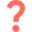 Сделайте вывод о влиянии функции расстояния ED и DTW на точность решения задач интеллектульного анализа данных, которые основаны на алгоритмах поиска по образцу.  

*# WRITE YOUR ANSWER*